Full name: ***Moldir Koishybayeva*** <br>
Course name: ***Machine Learning for MDE***<br>

<h1 align="center"> <font color=#F9AB00><b><i>Summarization of GitHub Issues</font></h4>

*This work was created in Google Colab.*<br>
*It will be appreciated if this platform will be used when running the code.*

##**Importing Necessary Packages**

In [1]:
from google.colab import output
!pip install transformers==4.2.0
!pip install torch==1.4.0
!pip install sentencepiece
!pip install datasets
!pip install sacrebleu
output.clear()

In [43]:
from google.colab import drive
import pandas as pd
import argparse
import json, re
import random
import copy
import nltk
import torch
from transformers import AutoTokenizer, BartForConditionalGeneration
from transformers import T5Tokenizer, T5ForConditionalGeneration, T5Config
from transformers import BertForMaskedLM, AutoTokenizer
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from datasets import load_metric
import numpy as np

##**Data Preprocessing**

In [3]:
# Mount Google Drive to the Colab notebook
drive.mount('/content/drive')

# Navigate to the folder where the data is stored in Google Drive
%cd /content/drive/My Drive/trial

# Load the data from a file in Google Drive
try:
    data = pd.read_json('raw_922730issues_reponobodytitle.json')
    print("Data loaded successfully.")
except:
    print('Please re-upload the correct file.')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/trial
Data loaded successfully.


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 922730 entries, 0 to 922729
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   number  922730 non-null  int64 
 1   title   922730 non-null  object
 2   body    922730 non-null  object
 3   repo    922730 non-null  object
dtypes: int64(1), object(3)
memory usage: 28.2+ MB


In [5]:
data.head()

,number,title,body,repo
0,35557,Add test to disallow extra characters in Appli...,In the challenge [Applied Accessibility: Stand...,freeCodeCamp/freeCodeCamp
1,14968,Running pytorch 1.0.0 on aws lambda,"## ❓ Questions and Help\r\n\r\nHello,\r\n\r\nI...",pytorch/pytorch
2,18448,Uncaught TypeError: Cannot read property 'endI...,[Enter steps to reproduce:]\r\n\r\n1. ...\r\n2...,atom/atom
3,37086,Ability to enable/disable replication controller,At present there isn't any way to temporarily ...,kubernetes/kubernetes
4,5531,[gatsby-plugin-sharp] Support Default Configur...,## Summary\r\n\r\nAt present there is no way t...,gatsbyjs/gatsby


In [6]:
#since we need to summarize issue for title generation, there is no need for data['number'] column
data.drop(columns = ['number'], inplace=True)

###**data['body'] column**
###**Replacing:** 

*   code snippets with word 'code'
*   added image link with word 'image'
*   hyperlink text with word 'link'
*   url text with word 'url'
*   new line with text 'new line'


In [7]:
#replacing code snippets with word 'code'
data['body'] = data['body'].replace(to_replace=re.compile(r'```(?:.|\n)+?```'), value=' code ', regex=True)
#replacing added image link with word 'image'
data['body'] = data['body'].replace(to_replace=re.compile(r'\!\[(.*?)\]\(.+?\)'), value=' image ', regex=True)
#replacing hyperlink text with word 'link'
data['body'] = data['body'].replace(to_replace=re.compile(r'(?<!\!)\[(.*?)\]\(.+?\)'), value=' link ', regex=True)
#replacing url text with word 'url'
data['body'] = data['body'].replace(to_replace=re.compile(r'(https?|ftp)://[^\s/$.?#].[^\s]*'), value=' url ', regex=True)
#replacing new line with text 'new line'
data['body'] = data['body'].replace(to_replace=re.compile(r'(\n\r)|(\r\n)|(\n)'), value=' ', regex=True)
#lowering text
data['body']= data['body'].apply(lambda row: row.lower())

###**data['title'] column**
###**Removing**:
*   tags
*   emphasis


In [8]:
#removing tags
data['title'] = data['title'].replace(to_replace=re.compile(r'^(\s*\[.*?\])+'), value='', regex=True)
#removing emphasis of "Important Issue" in bold
data['title'] = data['title'].replace(to_replace=re.compile(r'(\*{1,})(.+?)(\*{1,})'), value='', regex=True)
#lowering text
data['title']= data['title'].apply(lambda row: row.lower())

##**Exploratory Data Analysis**

Let's examine the dataset to get some interesting insights.

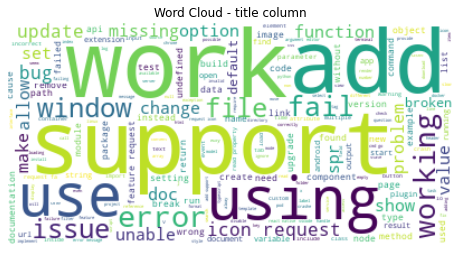

In [9]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

words_title = ' '.join(data['title'])
wcloud = WordCloud(background_color="white").generate(words_title)
plt.figure(figsize=(8,6))
plt.imshow(wcloud, interpolation='bilinear')
plt.title("Word Cloud - title column")
plt.axis("off")
plt.savefig("/content/sample_data/wordcloud1.png")
plt.show()

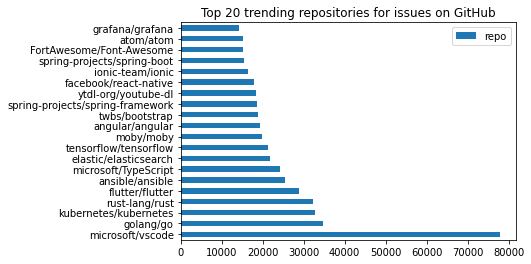

In [10]:
top20 = pd.DataFrame(data['repo'].value_counts()[:20])
plot = top20.plot.barh(title='Top 20 trending repositories for issues on GitHub')
fig = plot.get_figure()
fig.savefig("/content/sample_data/barh.png", dpi=70, bbox_inches = "tight")

In [11]:
top20

,repo
microsoft/vscode,77796
golang/go,34730
kubernetes/kubernetes,32704
rust-lang/rust,32198
flutter/flutter,28834
ansible/ansible,25461
microsoft/TypeScript,24323
elastic/elasticsearch,21772
tensorflow/tensorflow,21339
moby/moby,19719


In [12]:
data.drop(columns = ['repo'], inplace=True)

##**Model Training**

In [14]:
n = 50
# giving number for data['body'][n] to generate title

##**BART**

Example on a sample

In [32]:
# initialize tokenizer && model
model= "sshleifer/distilbart-cnn-6-6"
bart_tokenizer = AutoTokenizer.from_pretrained(model)
bart_model = BartForConditionalGeneration.from_pretrained(model)

# encoding input text
input_text = data['body'][n]
input_ids = bart_tokenizer.encode(input_text, return_tensors="pt")

# summary
summary_ids = bart_model.generate(input_ids, 
                             num_beams=1, 
                             max_length=20, 
                             min_length=10, 
                             length_penalty=2.0, 
                             early_stopping=True)

BART_issue_title = bart_tokenizer.decode(summary_ids[0], skip_special_tokens=True)

##**BERT**

Example on a sample

In [49]:
# Initialize the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
model = BertForMaskedLM.from_pretrained("bert-base-cased")

# Encode the input text
prompt = data['body'][n]
input_ids = tokenizer.encode(prompt, return_tensors="pt")

# Mask the last token (which is the summary)
input_ids[0][-1] = tokenizer.mask_token_id

# Generate the summary
summary_ids = model.generate(input_ids,num_beams=1, 
                             max_length=20, 
                             min_length=10, 
                             length_penalty=2.0, 
                             early_stopping=True)[0]
BERT_issue_title = tokenizer.decode(summary_ids, skip_special_tokens=True)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Input length of input_ids is 365, but ``max_length`` is set to 20.This can lead to unexpected behavior. You should consider increasing ``config.max_length`` or ``max_length``.


##**T5Model**

Example on a sample

In [36]:
# initialize tokenizer && model
model = T5ForConditionalGeneration.from_pretrained('t5-small')
tokenizer = T5Tokenizer.from_pretrained('t5-small')
device = torch.device('cpu')

text1=data['body'][n]

tokenized_text = tokenizer.encode(text1, return_tensors="pt").to(device)


# summmarize 
summary_ids = model.generate(tokenized_text,
                                    num_beams=1,
                                    no_repeat_ngram_size=2,
                                    min_length=10,
                                    max_length=20,
                                    early_stopping=True)

T5_issue_title = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

###**Comparing Generated Issue Titles**

In [50]:
print('Original text: \n', data['body'][n],  '\n')
print('BART: \n', BART_issue_title,  '\n')
print('BERT: \n',BERT_issue_title,  '\n')
print('T5: \n', T5_issue_title,  '\n')
print('Original title: \n', data['title'][n],  '\n')

Original text: 
 ** link ** opened ** link ** and commented  i set the location of a propertyplaceholderconfigurer to a bytearrayresource and got this error upon starting up:  java.lang.illegalstateexception: resource loaded from byte array does not have a filename at org.springframework.core.io.abstractresource.getfilename(abstractresource.java:157) at org.springframework.core.io.support.propertiesloadersupport.loadproperties(propertiesloadersupport.java:182) at org.springframework.core.io.support.propertiesloadersupport.mergeproperties(propertiesloadersupport.java:161) at org.springframework.beans.factory.config.propertyresourceconfigurer.postprocessbeanfactory(propertyresourceconfigurer.java:69) at org.springframework.context.support.abstractapplicationcontext.invokebeanfactorypostprocessors(abstractapplicationcontext.java:663) at org.springframework.context.support.abstractapplicationcontext.invokebeanfactorypostprocessors(abstractapplicationcontext.java:603) at org.springframework

##**Evaluation**

###**BLEU**

In [44]:
bleu_metric = load_metric("sacrebleu")

def bleu_evaluate(pred, ref):
  bleu_metric.add(prediction= pred, reference=ref.split())
  results = bleu_metric.compute(smooth_method="floor", smooth_value=0)
  results["precisions"] = [np.round(p, 2) for p in results["precisions"]]
  results = pd.DataFrame.from_dict(results, orient="index", columns=["Value"])
  return results

<ipython-input-44-c0c2c050db5f>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  bleu_metric = load_metric("sacrebleu")


In [45]:
bleu_evaluate(BART_issue_title, data['title'][100]) 

,Value
score,0.0
counts,"[0, 0, 0, 0]"
totals,"[19, 18, 17, 16]"
precisions,"[0.0, 0.0, 0.0, 0.0]"
bp,1.0
sys_len,19
ref_len,1


In [46]:
bleu_evaluate(T5_issue_title, data['title'][100]) 

,Value
score,0.0
counts,"[0, 0, 0, 0]"
totals,"[14, 13, 12, 11]"
precisions,"[0.0, 0.0, 0.0, 0.0]"
bp,1.0
sys_len,14
ref_len,1


In [51]:
bleu_evaluate(BERT_issue_title, data['title'][100]) 

,Value
score,0.0
counts,"[0, 0, 0, 0]"
totals,"[211, 210, 209, 208]"
precisions,"[0.0, 0.0, 0.0, 0.0]"
bp,1.0
sys_len,211
ref_len,1
